In [1]:
import subprocess
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [2]:
#prob_dep_multi_label_ double_dep_multi_label_ sev_dep_multi_label_  'Probably Depressed'  double_depressed severely_depressed
df ="Val_demographics_covariates.csv"
label = "Age"

In [3]:
df = pd.read_csv(f"../00_data/{df}")

In [4]:
df.columns

Index(['ID', 'Sex', 'Age', 'Site'], dtype='object')

In [5]:
columns_to_use = ["ID", 'Sex','Site']

In [6]:
demo = df[columns_to_use]
label_df = df[["ID", label]]

In [7]:
demo

,ID,Sex,Site
0,10159,1,35343.0
1,10171,0,35343.0
2,10189,0,35343.0
3,10193,0,35343.0
4,10206,0,35343.0
...,...,...,...
267,70079,0,35426.0
268,70080,0,35426.0
269,70081,0,35426.0
270,70083,1,35426.0


In [8]:
rename_dict = {
    "Sex": "sex",
    "Site" : "assessment_centre"
}
demo.rename(columns=rename_dict, inplace=True)

/tmp/ipykernel_1484913/2344452251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo.rename(columns=rename_dict, inplace=True)


In [9]:
unique_centers = demo["assessment_centre"].unique()
center_mapping = {center: idx for idx, center in enumerate(unique_centers)}
print("Mapping of assessment centers to numbers:")
for center, idx in center_mapping.items():
    print(f"{center}: {idx}")
demo["assessment_centre"] = demo["assessment_centre"].map(center_mapping)

Mapping of assessment centers to numbers:
35343.0: 0
35426.0: 1


/tmp/ipykernel_1484913/569741917.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo["assessment_centre"] = demo["assessment_centre"].map(center_mapping)


In [10]:
nan_summary = demo.isnull().sum()
nan_columns = nan_summary[nan_summary > 0]
print(nan_columns)

# Iterate through each column with missing values
for col in demo.columns:
    if demo[col].isna().any(): 
        if demo[col].dtype in ['int64', 'float64']:  # Only apply IQR method for numeric columns
            Q1 = demo[col].quantile(0.25)  # First quartile
            Q3 = demo[col].quantile(0.75)  # Third quartile
            iqr_values = demo[col][(demo[col] >= Q1) & (demo[col] <= Q3)]
            
            if not iqr_values.empty:  # Ensure we have values to sample from
                random_values = np.random.choice(iqr_values, size=demo[col].isnull().sum())
                demo.loc[demo[col].isnull(), col] = random_values
        else:  # For categorical columns, fill with mode
            mode_value = demo[col].mode()[0]
            demo[col].fillna(mode_value, inplace=True)

# Check for remaining NaN columns
nan_summary = demo.isnull().sum()
nan_columns = nan_summary[nan_summary > 0]
print(nan_columns)

Series([], dtype: int64)
Series([], dtype: int64)


In [11]:
merged_df = demo.merge(label_df, on="ID", how="inner")

In [12]:
merged_df.columns

Index(['ID', 'sex', 'assessment_centre', 'Age'], dtype='object')

In [13]:
#merged_df["deprivation_index"].describe()

In [14]:
merged_df.rename(columns={label:f"label_{label}"},inplace=True)

In [15]:
merged_df.columns

Index(['ID', 'sex', 'assessment_centre', 'label_Age'], dtype='object')

In [16]:
def match_participant(target_row, df_candidates, relax_order, used_ids,thresholds=None):
    df_candidates = df_candidates[~df_candidates['ID'].isin(used_ids)].copy()
    for relax_level in relax_order:
        filtered = df_candidates.copy()
        for criterion, match_exact in relax_level.items():
            if criterion in ['assessment_centre']:
                if match_exact:
                    filtered = filtered[filtered[criterion] == target_row[criterion]]
            elif criterion in ['sex']:
                if match_exact:
                    #find opposite sex
                    filtered = filtered[filtered[criterion] != target_row[criterion]]
            else:
                if match_exact:
                    diff = abs(filtered[criterion] - target_row[criterion])
                    filtered = filtered[diff <= thresholds[criterion]]
            if filtered.empty:
                break
        if not filtered.empty:
            return filtered.iloc[0]
    print("NO candidate found")
    return None
""" relax_order = [
    {'assessment_centre': True, 'deprivation_index': True, 'bmi': True, 'age_at_assessment': True, 'sex': True},
    {'assessment_centre': False, 'deprivation_index': True, 'bmi': True, 'age_at_assessment': True, 'sex': True},
    {'assessment_centre': False, 'deprivation_index': False, 'bmi': True, 'age_at_assessment': True, 'sex': True},
    {'assessment_centre': False, 'deprivation_index': False, 'bmi': False, 'age_at_assessment': True, 'sex': True},
    {'assessment_centre': False, 'deprivation_index': False, 'bmi': False, 'age_at_assessment': False, 'sex': True},
] """
""" thresholds = {
    'age_at_assessment': 2,
    'bmi': 3,
    'deprivation_index': 1
}
 """
relax_order = [
    {'assessment_centre': True, "label_Age": True},
    {'assessment_centre': False, "label_Age": True},
]
thresholds = {
    "label_Age": 2
}

In [17]:
from joblib import Parallel, delayed
import os
def match_for_label(label, merged_df, relax_order, thresholds=None):
    positive_group = merged_df[merged_df[label] == 1]
    negative_group = merged_df[merged_df[label] == 0]

    matches = []
    used_ids = set() 
    for _, target_row in positive_group.iterrows():
        matched = match_participant(target_row, negative_group, relax_order, used_ids, thresholds)
        if matched is not None:
            matches.append(matched)
            used_ids.add(matched['ID'])
    matched_df = pd.DataFrame(matches)
    return label, matched_df, positive_group

label_cols = [col for col in merged_df.columns if "sex" in col]
print(f"label_cols: {label_cols}")
results = Parallel(n_jobs=-1)(delayed(match_for_label)(label, merged_df, relax_order, thresholds) for label in label_cols)




label_cols: ['sex']


In [74]:
len(results)

1

In [18]:
for label, matched_df, positive_group in results:
    print(matched_df[label].value_counts())
    print(positive_group[label].value_counts())

sex
0    117
Name: count, dtype: int64
sex
1    117
Name: count, dtype: int64


In [19]:
list_of_final_dfs = []
os.makedirs("/zi/home/esra.lenz/Documents/00_HITKIP/00_CLIP/00_NAKO/02_Validation_of_UKB/01_Validation_data_set/00_data/matched_depression", exist_ok=True)
for label, matched_df, positive_group in results:
    #concat the the positive and negative matched participants
    final_df = pd.concat([positive_group, matched_df])
    #matched_df.to_csv(f"/zi/home/esra.lenz/Documents/00_HITKIP/00_CLIP/00_NAKO/02_Validation_of_UKB/00_data/matched_depression/matched_{label}.csv", index=False)
    list_of_final_dfs.append(final_df)
    print(f"Saved matched participants for {label}")

Saved matched participants for sex


In [20]:
df = list_of_final_dfs[0]

<Axes: >

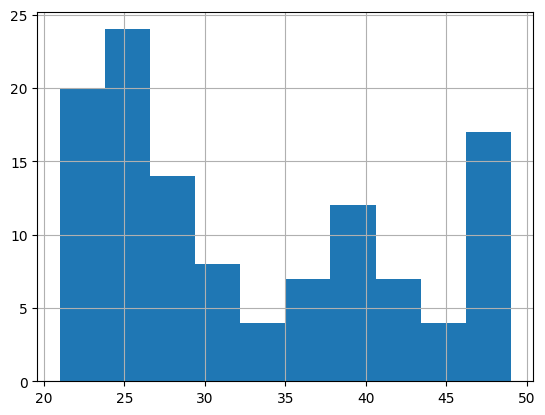

In [21]:
df[df["sex"] == 0]["label_Age"].hist()

<Axes: >

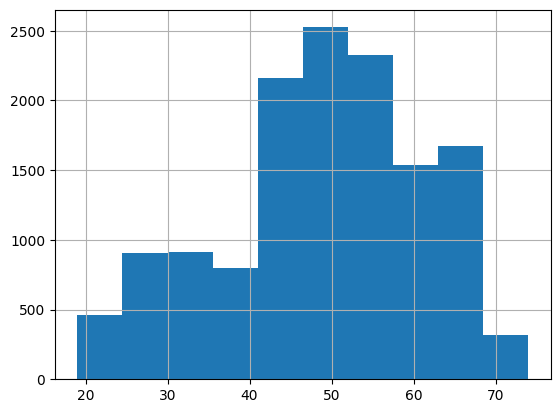

In [80]:
df[df["sex"] == 1]["label_Age"].hist()

In [29]:
df.to_csv("/zi/home/esra.lenz/Documents/00_HITKIP/09_TABPFN/01_Validation_data_set/00_data/age_label/all_ages.csv", index=False)

In [127]:
from typing import List
def balance_dataframe(df: pd.DataFrame, label_col: str, sex_col: str, sort_col: List[str], ascending: List[bool] = [True]) -> pd.DataFrame:
    """
    Balances a DataFrame by equalizing the number of male and female entries in the positive class.
    
    Args:
    - df (pd.DataFrame): The input DataFrame.
    - label_col (str): The name of the column containing the binary labels (0 or 1).
    - sex_col (str): The name of the column containing the sex indicator (0 for women, 1 for men).
    - sort_col (str): The column to sort by when dropping excess rows from the dominant sex.
    
    Returns:
    - pd.DataFrame: The balanced DataFrame with an equal number of men and women in the positive class.
    """
    # Separate the false and positive classes
    df_false = df[df[label_col] == 0].reset_index(drop=True)
    df_pos = df[df[label_col] == 1].reset_index(drop=True)
    
    # Count the number of men and women in the positive class
    count_men = len(df_pos[df_pos[sex_col] == 1])
    count_women = len(df_pos[df_pos[sex_col] == 0])
    
    # Calculate the difference and identify the dominant class (1 for men, 0 for women)
    difference = abs(count_men - count_women)
    dominant_class = int(count_men > count_women)
    
    # Sort the positive class by the specified column
    pos_sorted_for_units_ascending = df_pos.sort_values(by=sort_col, ascending=ascending)
    
    # Get the dominant class subset and drop the excess indices
    just_dominant_class = pos_sorted_for_units_ascending[pos_sorted_for_units_ascending[sex_col] == dominant_class]
    drop_indices = just_dominant_class.index[:difference]
    
    # Drop the excess indices from both the positive and false class DataFrames
    df_pos = df_pos.drop(drop_indices).reset_index(drop=True)
    df_false = df_false.drop(drop_indices).reset_index(drop=True)
    
    # Concatenate the balanced DataFrame
    df_balanced = pd.concat([df_pos, df_false]).reset_index(drop=True)
    
    return df_balanced




In [133]:
os.makedirs("/zi/home/esra.lenz/Documents/00_HITKIP/00_CLIP/00_NAKO/02_Validation_of_UKB/00_data/sex_balanced_labels_depression/", exist_ok=True)
for final_df, label in zip(list_of_final_dfs, label_cols):
    gender_balanced_df = balance_dataframe(final_df, label, "sex", sort_col="a_emo_phq9_sum", ascending=True)
    print(f"#####\nVALUE COUNT: {gender_balanced_df[label].value_counts()}")
    print(f"VALUE COUNT: {gender_balanced_df['sex'].value_counts()}\n")
    gender_balanced_df.to_csv(f"/zi/home/esra.lenz/Documents/00_HITKIP/00_CLIP/00_NAKO/02_Validation_of_UKB/00_data/sex_balanced_labels_depression/sex_balanced_{label}.csv", index=False, mode='w')

    

#####
VALUE COUNT: label_diagnosis_depression_3
1    546
0    546
Name: count, dtype: int64
VALUE COUNT: sex
0    546
1    546
Name: count, dtype: int64



<Axes: >

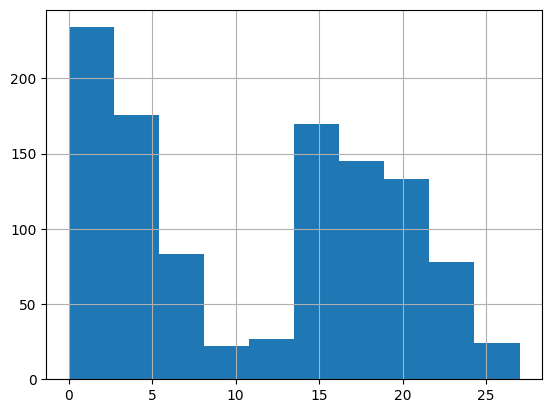

In [134]:
gender_balanced_df["a_emo_phq9_sum"].hist()